# Analyse av barnehagene i bydel Gamle Oslo 2026
Å valge barnehage til barnet sitt er ikke enkelt. Det er vanskelig å finne sammenstilt informasjon og man hører så mye rart fra diverse foreldre. Heldigvis finnes det data som kan gjøre valget mer opplyst. 

Analysen bruker data fra Foreldreundersøkelsen som gjennomføres hvert år av Udir. Foreldrene scorer barnehagen på en skala fra 1 til 5. Tallene er lastet ned [herfra.](https://www.udir.no/tall-og-forskning/statistikk/statistikk-barnehage/fuba-resultater-alle-sporsmal/)

Barnehager som ikke har tall fra foreldreundersøkelsen er ikke en del av analysen. Ifølge [Oslo kommune](https://www.oslo.kommune.no/barnehage/finn-barnehage-i-oslo/) er det 55 barnehager i bydelen. I denne analysen er det 44. I tillegg er det ikke tatt hensyn til svarprosent, og dermed usikkerhet knyttet til poengsummen. Datasettet lider av de samme svakhetene som data fra spørreundersøkelser lider av. Det er derfor viktig å innhente informasjon fra flere steder da den perfekte barnehagen kan mangle tall fra foreldreundersøkelsen. 

I tillegg brukes kartdata til for å kartlegge avstanden mellom hjem og barnehager. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from geopy.geocoders import Nominatim
import time
import folium
from geopy.distance import distance
from scipy.stats import norm
from scipy import stats

In [2]:
os.chdir("/home/madsranden/Documents/barnehage_analyse")
df = pd.read_csv(
    "foreldreundersokelsen_20_02_2026.csv",
    sep="\t",
    encoding="utf-16-le",
    skiprows=1,
    decimal=","
)

In [3]:
#Variabelnavnene er altfor lange og inneholder for mye informasjon. Jeg må fjerne alle informasjon som ikke angir barnehagen. 
df.columns = (
    df.columns
    .str.replace("2026.Hele landet.Oslo.Gamle Oslo.", "", regex=False)
    .str.replace(".Alle barnehagestørrelser.", "", regex=False)
    .str.replace(".Alle aldersgrupper.Alle kjønn.", "", regex=False)
)

df.columns = (
    df.columns
    .str.replace("Snitt", "", regex=False)
)

In [4]:
#Lager liste med barnehager som skal brukes. Vil bare ha med gjennomsnittlig score.
barnehage_kolonner = []

for col in df.columns:
    if "barnehage" in col:
        if "Antall besvart" not in col and "Svarprosent" not in col:
            barnehage_kolonner.append(col)

In [5]:
df_filtrert = df.melt(id_vars = ["Spoersmaalnavn", "SpoersmaalNivaa", "Spoersmaalgruppe", "SvaralternativNavn"],
                      value_vars = barnehage_kolonner,
                      var_name = "Barnehage",
                      value_name = "Gjennomsnitt"
                     )

df_filtrert["Gjennomsnitt"] = (
    df_filtrert["Gjennomsnitt"]
        .astype(str)
        .str.strip()
        .replace("*", pd.NA)
        .str.replace(",",".", regex=False)
)

df_filtrert["Gjennomsnitt"] = pd.to_numeric(df_filtrert["Gjennomsnitt"], errors="coerce")

df_filtrert_niva1 = df_filtrert[df_filtrert["SpoersmaalNivaa"]==1].dropna()
df_filtrert_niva2 = df_filtrert[(df_filtrert["SpoersmaalNivaa"]==2) & (df_filtrert["SvaralternativNavn"]=="Alle svar")].dropna()

#Lang versjon
df_filtrert_niva1_long = df_filtrert_niva1.pivot(columns = "Spoersmaalgruppe",
                                                 values = "Gjennomsnitt",
                                                 index  ="Barnehage"
                                           ).reset_index()
#Legger til eierform
df_filtrert_niva1_long["Eierform"] = np.where(
    df_filtrert_niva1_long["Barnehage"]
        .str.contains("Privat"), 
    "Privat", "Kommunal"
)


#Fjerner privat i barnehage-variabelen
df_filtrert_niva1_long["Barnehage"] = df_filtrert_niva1_long["Barnehage"].str.replace("Privat","", regex=False)
df_filtrert_niva1_long["Barnehage"] = df_filtrert_niva1_long["Barnehage"].str.replace("Kommunal", "", regex=False)

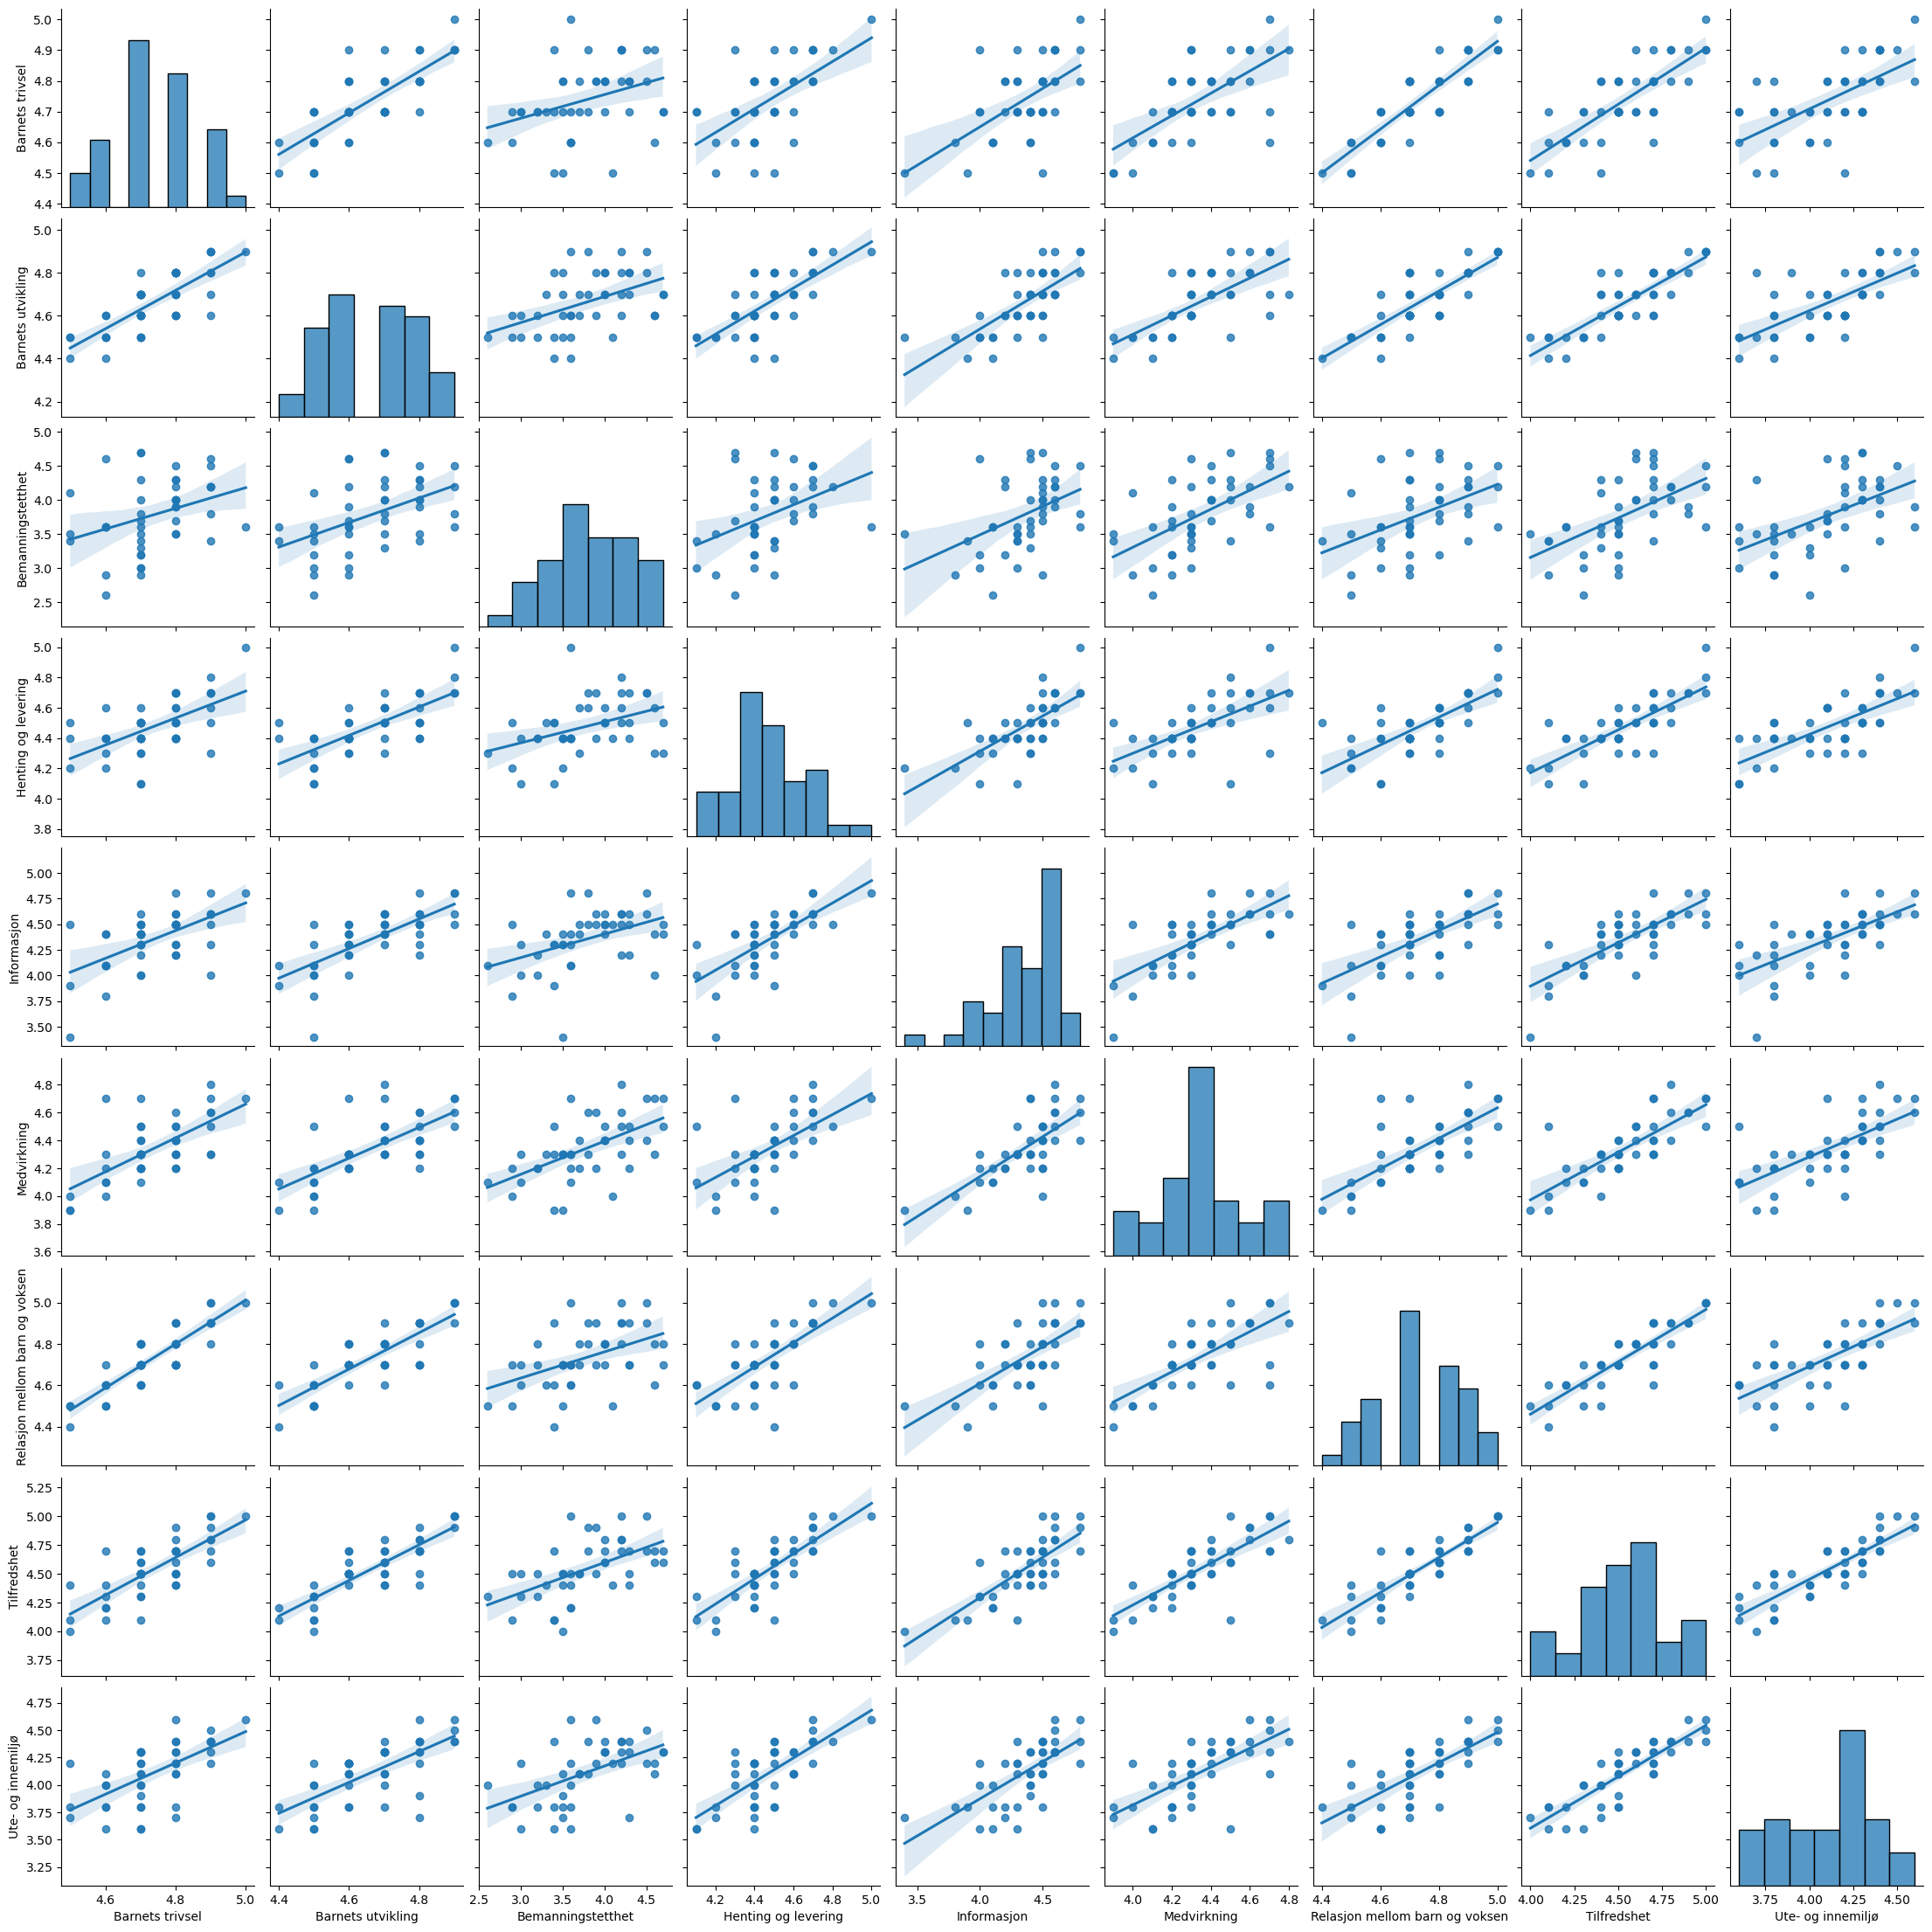

In [6]:
sns.pairplot(data=df_filtrert_niva1_long.select_dtypes(include="number"),
            kind="reg")
plt.show()

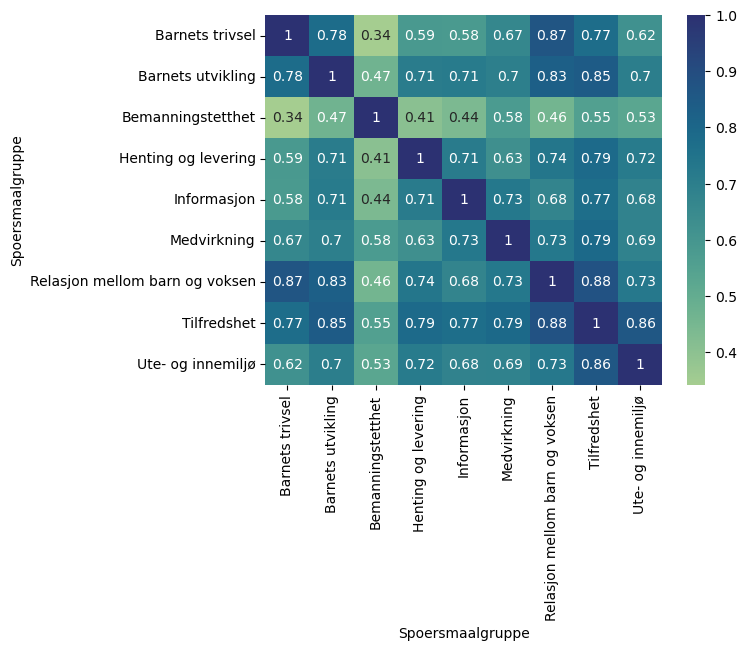

In [7]:
corr_matrix = (
    df_filtrert_niva1_long
        .select_dtypes(include="number")
        .corr()
)

sns.heatmap(data=corr_matrix,
           cmap="crest",
           annot=True)
plt.show()

Det er en tydelig positiv sammenheng mellom alle indikatorene. Dette bekreftes i varmekartet som fremstiller korrelasjonskoeffisienten mellom de ulike variablene. I de fleste sammenhenger vil det derfor være tilstrekkelig å se på færre indikatorer. Den viktigste indikatoren er antatt å være "tilfredshet" som oppsummerer det totale inntrykket av barnehagen. I tilfeller der det ikke finnes verdier for variabelen "tilfredshet" brukes gjennomsnittet av variabelne som allerede finnes. 

Som et suplement til den totale tilfredsheten beregner jeg en ny variabel som er basert på gjennomsnittet av de øvrige indikatorene. Dersom disse indikatorene fanget opp alt av foreldres inntrykk av barnehagen, foreldre vektet kategoriene likt og foreldre svarer logisk konsistent, burde denne variabelen og "tilfredshet" vært indentisk. Dette er mest sannsynlig ikke tilfelle da minst et av kriteriene (mest sannsynlig alle) listet opp over ikke er oppfylt. 

Punktdiagrammet under viser at det er tett sammenheng mellom den totale tilfredsheten og snittet av de andre inikatorene. Sammenhengen er imidlertid ikke perfekt. 

In [8]:
#Fyll NAs basert på gjennomsnittet for barnehagen
num_cols = df_filtrert_niva1_long.select_dtypes(include="number").columns

df_filtrert_niva1_long[num_cols] = df_filtrert_niva1_long[num_cols].apply(
    lambda row: row.fillna(row.mean()), axis=1
)

#Lager nytt mål basert på gjennomsnittlig score i undersøkelsen. Dropper "tilfredshet" da det er et samlemål
df_filtrert_niva1_long["Gjennomsnittlig_score"] = df_filtrert_niva1_long[num_cols.drop("Tilfredshet")].apply(
    lambda row: row.mean(), axis=1
)

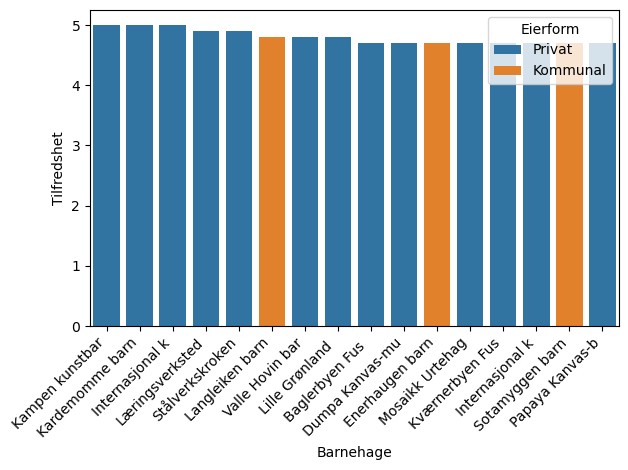

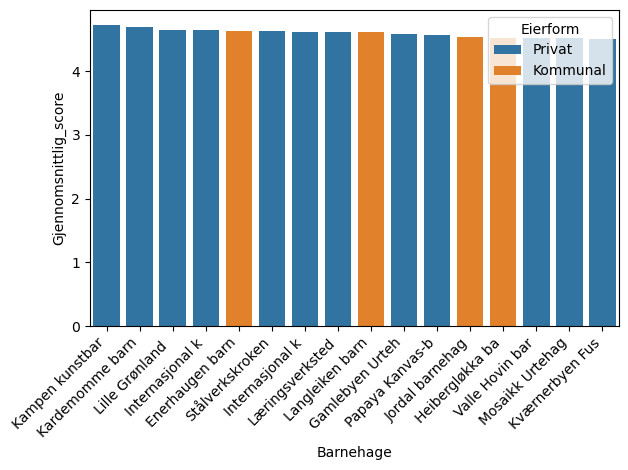

In [9]:
df_sorted_tilfreds = (
    df_filtrert_niva1_long
        .sort_values("Tilfredshet", ascending = False)
        .iloc[:16])

df_sorted_barnet = (
    df_filtrert_niva1_long
        .sort_values("Gjennomsnittlig_score", ascending = False)
        .iloc[:16])

sns.barplot(data=df_sorted_tilfreds,
            x="Barnehage",
            y="Tilfredshet",
           hue="Eierform")
plt.xticks(rotation=45, 
           ha="right",
           ticks=range(len(df_sorted_tilfreds["Barnehage"])),
           labels=[v[:15] for v in df_sorted_tilfreds['Barnehage']])
plt.tight_layout()
plt.show()

sns.barplot(data=df_sorted_barnet,
            x="Barnehage",
            y="Gjennomsnittlig_score",
           hue="Eierform")
plt.xticks(rotation=45, 
           ha="right",
           ticks=range(len(df_sorted_barnet["Barnehage"])),
           labels=[v[:15] for v in df_sorted_barnet['Barnehage']])
plt.tight_layout()
plt.show()


Som ventet er det mange av de samme barnehagene som gjør det bra både på total tilfredshet og på gjennomsnittlig score på de andre indikatorene. Dette kommer også frem i punktdiagrammet under.

Private barnehager utgjør en større andel av topplisten for begge indikatorene. Dette er tilfellet til tross for at det er færre private barnehager i datasettet. 

Figurene under viser at private barnehager generelt scorer i snitt signifikant bedre enn kommunale i bydelen. Den beste og dårligste poengsummen er bedre sammenlignet med kommunale og spredningen er mindre. 

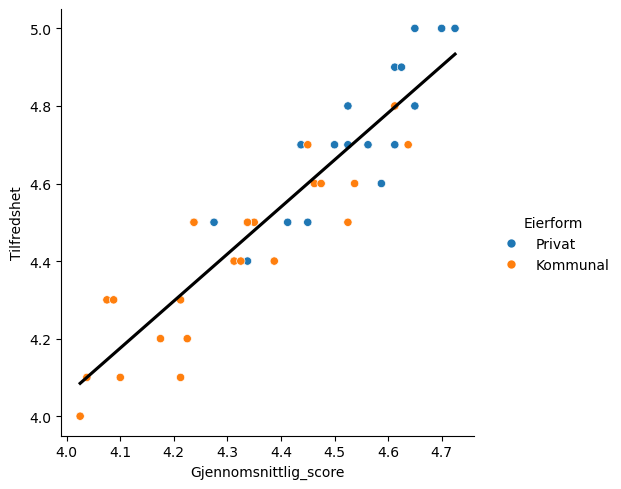

In [10]:
g = sns.relplot(data=df_filtrert_niva1_long,
            x="Gjennomsnittlig_score",
            y="Tilfredshet",
            hue="Eierform",
            kind="scatter"
                )

g.map_dataframe(
    sns.regplot,
    x="Gjennomsnittlig_score",
    y="Tilfredshet",
    scatter=False,
    ci=None,
    color="black"
)
plt.show()

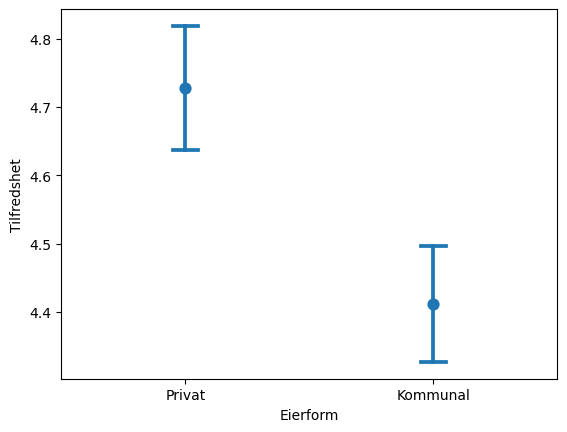

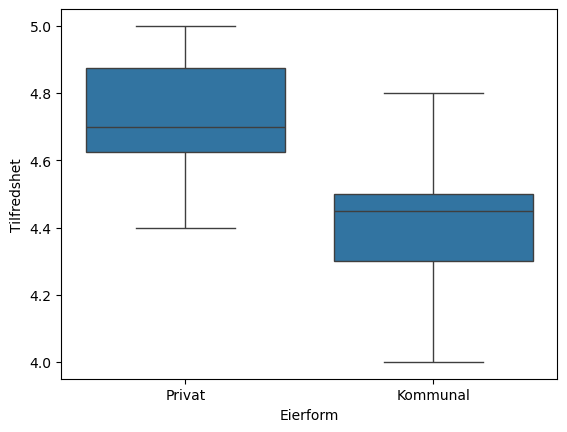

In [11]:
t_crit = stats.t.ppf(0.975, df=18) #T-fordeling gitt liten n.

sns.pointplot(data=df_filtrert_niva1_long, 
              y="Tilfredshet", x="Eierform",  
              errorbar=('se', t_crit), #Burde egentlig regnes separat for disse men er her på den trygge siden
             capsize=0.1,
             linestyle="none")
plt.show()

sns.boxplot(data=df_filtrert_niva1_long, 
              y="Tilfredshet", x="Eierform")
plt.show()

## Avstand til barnehage

In [12]:
geolocator = Nominatim(user_agent="barnehager")

# Funksjon for å geokode én barnehage
def geocode_bedrift(navn):
    query = f"{navn}, Gamle Oslo, Oslo, Norge"
    try:
        location = geolocator.geocode(query)
        if location:
            return location.latitude, location.longitude
    except Exception as e:
        print(f"Feil ved geokoding: {e} for {query}")
    return None, None

barnehage_kolonner = [x.replace("Privat", "") for x in barnehage_kolonner]
barnehage_kolonner = [x.replace("Kommunal", "") for x in barnehage_kolonner]

df_geo = pd.DataFrame({
    "Barnehage": barnehage_kolonner,
    "Latitude" : [np.nan]*len(barnehage_kolonner),
    "Longitude" : [np.nan]*len(barnehage_kolonner)
})


#Looper over barnehagene og legger koordinater
for idx in df_geo.index: 
    location = geocode_bedrift(df_geo.iloc[idx,0])
    df_geo.iloc[idx, 1] = location[0]
    df_geo.iloc[idx, 2] = location[1]
    time.sleep(1.5) #For å ikke overstige grensen for api-kall


print(df_geo[df_geo["Latitude"].isna()]) #Endel missing. Fikser de manuelt

                                   Barnehage  Latitude  Longitude
1                Baglerbyen Fus barnehage AS       NaN        NaN
11         Gamlebyen Urtehagen barnehager AS       NaN        NaN
13          Grønland Urtehagen barnehager AS       NaN        NaN
18  Internasjonal kulturbarnehage Åkeberg AS       NaN        NaN
23              Kværnerbyen Fus barnehage AS       NaN        NaN
30           Mosaikk Urtehagen barnehager AS       NaN        NaN
33                   Normannsløkka barnehage       NaN        NaN
39              Stålverkskroken barnehage AS       NaN        NaN


In [13]:
index_na = df_geo[df_geo["Latitude"].isna()].index

mangler_koord = [
    (59.90300, 10.77440),
    (59.90551, 10.76720),
    (59.91509, 10.76191),
    (59.90832, 10.77818),
    (59.90317, 10.78870),
    (59.91450, 10.76421),
    (59.91762, 10.78511),
    (59.91817, 10.79039)
]

df_coords = pd.DataFrame(
    mangler_koord,
    index=index_na,
    columns=["Latitude", "Longitude"]
)

df_geo.update(df_coords, overwrite=False)

### Kombinasjon av avstand og score i foreldreundersøkelsen
For å finne vår beste barnehageamatch er det nødvendlig å kombinere tallene fra Foreldreundersøkelsen og avstand fra hjemmet.

Det er likevel viktig å være klar over at dette kan få noen rare utslag. Mange barnehager som ligger i nærheter er tungvinte å levere til i forbindelse med jobb. Dette er barnehager som ikke er på vei til jobb eller kollektiv transport. Eksmepler på dette er barnehager i Kværnerbyen og Etterstad. På samme måte finnes det barnehager som ligger lengre unna som likevel kan være gode alternativer fordi de er enkle å levere til. Dette er typisk barnehager som ligger i retning sentrum.

Det er mange måter å kombinere avstand og score fra foreldreundersøkelsen. En metode, som gir en intuitiv tolkning, er å la begge være på den samme skalaen. Dette gjør det enkelt å sammenstille dem. Siden Foreldreundersøkelsen tar i bruk en skala mellom 1 og 5, er det enkelst å også bruke den for avstandsmålet. 

Scoren på total tilfredshet bruker imidlertid ikke hele skalaen. Den største verdien er `5`, men den minste verdien er så høy som `3,7`. Dersom avstandsmålet hadde brukt hele skalaen, ville målet fått uforholdsmessig stor vekt. En bedre metode er derfor å bare bruke skalaen mellom 3,7 og 5. Deretter kan dette vektes senere. 

In [14]:
#Legger til hjem
hjem = geocode_bedrift("Hedmarksgata 4")

#Lager variabel med avstand mellom hjem og barnehage
df_geo["Avstand_hjem_m"] = df_geo.apply(
    lambda row: distance((row["Latitude"], row["Longitude"]), hjem).m, axis=1
)

print(df_geo.head())

                      Barnehage   Latitude  Longitude  Avstand_hjem_m
0              Alleen barnehage  59.914680  10.794545      641.506297
1   Baglerbyen Fus barnehage AS  59.903000  10.774400     1099.957876
2            Breigata barnehage  59.913936  10.760610     1652.087156
3  Dumpa Kanvas-musikkbarnehage  59.906528  10.800369      731.478363
4      Eitillstad Fus barnehage  59.904965  10.794130      600.669134


In [26]:
#Lager trinn for å gir en score
trinn = np.linspace(5, 4, 10)
print(trinn)

[5.         4.88888889 4.77777778 4.66666667 4.55555556 4.44444444
 4.33333333 4.22222222 4.11111111 4.        ]


In [27]:
#Regner ut hvilken gruppe desilgruppe de ulike obs hører til
df_geo["Avstand_desil"] = pd.qcut(df_geo["Avstand_hjem_m"], 10, labels=False) + 1

#Basert på desilgruppen tildelses score på avstand. Dette gir en uniform fordeling
df_geo["Avstand_score"] = (
    pd.cut(
    df_geo["Avstand_desil"],
    bins=np.linspace(0,10,11),
    labels=trinn)
    .astype(float)
)


In [28]:
#Alternativ som følger fordelingen til avstandsmålet
maal = df_geo["Avstand_hjem_m"].agg(["mean", "std"])

bins_norm = []


for i in np.linspace(0,1,11):
    qtile = norm.ppf(i, loc=maal.iloc[0], scale = maal.iloc[1])
    bins_norm.append(qtile)


bins_norm[0] = df_geo["Avstand_hjem_m"].min()-1
bins_norm[-1] = df_geo["Avstand_hjem_m"].max()+1

df_geo["Avstand_score_norm"] = (
    pd.cut(
    df_geo["Avstand_hjem_m"],
    bins=np.linspace(df_geo["Avstand_hjem_m"].min()-1, df_geo["Avstand_hjem_m"].max()+1, 11),
    labels=trinn)
    .astype(float)
)

In [29]:
#Merger datasett
df_merged = pd.merge(
    df_filtrert_niva1_long, 
    df_geo, 
    on="Barnehage", 
    how="left")

In [33]:
#Regner ut totalscore
vekt_undersokelse = 0.3
vekt_avstand = 1-vekt_undersokelse

df_merged["Total_score"] = df_merged["Tilfredshet"]*vekt_undersokelse + df_merged["Avstand_score_norm"]*vekt_avstand
df_merged["Total_score_gjennomsnitt_indikatorer"] = df_merged["Gjennomsnittlig_score"]*vekt_undersokelse + df_merged["Avstand_score_norm"]*vekt_avstand



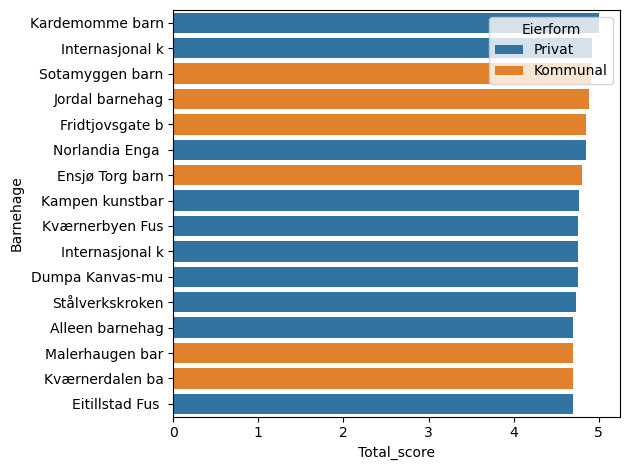

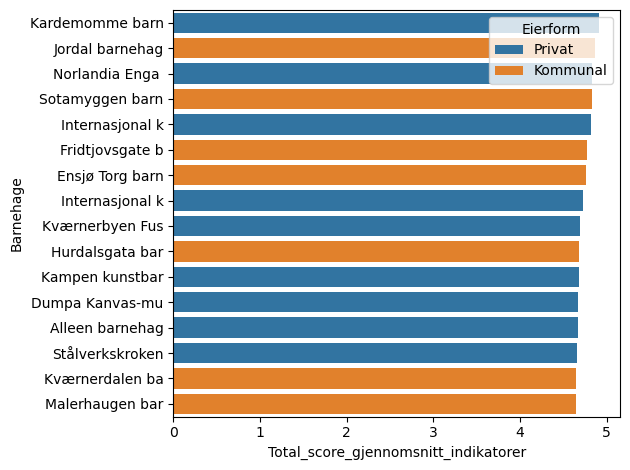

In [34]:
df_sorted_merged = (
    df_merged
        .sort_values("Total_score", ascending = False)
        .iloc[:16])

df_sorted_merged_gjennomsnitt = (
    df_merged
        .sort_values("Total_score_gjennomsnitt_indikatorer", ascending = False)
        .iloc[:16])


sns.barplot(data=df_sorted_merged,
            y="Barnehage",
            x="Total_score",
           hue="Eierform")
plt.yticks(ha="right",
           ticks=range(len(df_sorted_merged["Barnehage"])),
           labels=[v[:15] for v in df_sorted_merged['Barnehage']])
plt.tight_layout()
plt.show()


sns.barplot(data=df_sorted_merged_gjennomsnitt,
            y="Barnehage",
            x="Total_score_gjennomsnitt_indikatorer",
           hue="Eierform")
plt.yticks(ha="right",
           ticks=range(len(df_sorted_merged_gjennomsnitt["Barnehage"])),
           labels=[v[:15] for v in df_sorted_merged_gjennomsnitt['Barnehage']])
plt.tight_layout()
plt.show()

Figurene viser at det Kardemomme barnehage som er den beste totalpakka for oss, gitt at avstand teller 70 pst. og foreldreundersøkelsen teller 30 pst.  

Topplisten er dominert av private barnehager. Det sies at det er vanskelig å komme inn i en privat barnehage dersom man ikke har den på førsteplass. En mulighet er derfor å ha en privat barnehage på førsteplass og fylle opp resten av søknaden med kommunale. Det er innteressant å bare se på de kommunale barnehagene.

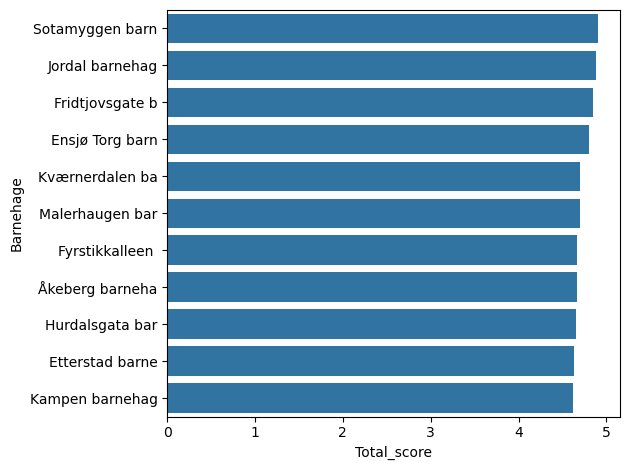

In [35]:
df_sorted_merged_kommunal = (
    df_merged.loc[df_merged["Eierform"]=="Kommunal",:]
        .sort_values("Total_score", ascending = False)
        .iloc[:11])

sns.barplot(data=df_sorted_merged_kommunal,
            y="Barnehage",
            x="Total_score")
plt.yticks(ha="right",
           ticks=range(len(df_sorted_merged_kommunal["Barnehage"])),
           labels=[v[:15] for v in df_sorted_merged_kommunal["Barnehage"]])
plt.tight_layout()
plt.show()

In [36]:
#Mapper på kart
kart = folium.Map(
    location=[59.91367, 10.77889],
    zoom_start=14
)

for idx in df_merged.index:
    if not pd.isna(df_merged.loc[idx, "Latitude"]):
        folium.Marker(
            location=[
                df_merged.loc[idx, "Latitude"],
                df_merged.loc[idx, "Longitude"]
            ],
            tooltip = df_merged.loc[idx, "Barnehage"],
            popup=f"{df_merged.loc[idx, "Barnehage"]}, Tilfredshet: {df_merged.loc[idx, "Tilfredshet"]}"
        ).add_to(kart)

#Legger til hjem

folium.Marker(
    location = [hjem[0], hjem[1]],
    tooltip = "Hjem",
    popup="Hjem",
    icon=folium.Icon(color="red")
).add_to(kart)

#Legger til raddius på en kilometer rundt hjem
folium.Circle(
    location=[hjem[0], hjem[1]],
    radius=1000,
    color="red",
    fill=True,
    fill_opacity=0.2
).add_to(kart)

kart